In [33]:
import torch
import os 
from models import * 
from utils import *
from metrics import *
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import pandas as pd
from tabulate import tabulate
import mne
from pytorch_lightning import Trainer
import torchinfo 
from utils import ReconstructionLoss

mne.set_log_level('ERROR') 

project_path = os.getcwd()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 16
epochs = 50
learning_rate = 0.001
seeds = [42, 7, 21, 84]
fs_hr = 160
seconds = 10 #9760 samples /160 Hz = 61 seconds

#runs = range(1, 14)  # EEG recording runs per subject
runs = [3, 4]  # For quicker testing, use only first 4 runs

quick_load = True # if True, load preprocessed data if available

nfolds = 1 # Number of folds for cross-validation

lr_window_length = fs_hr * seconds  # Low-resolution window length
hr_window_length = fs_hr * seconds  # High-resolution window length

#print(fs_lr, fs_hr, lr_window_length, hr_window_length)

torch.set_float32_matmul_precision('medium')

demo = True # Set to True for a quick demo run
debug = False
if demo:
    print("Demo mode activated: Using smaller dataset and fewer epochs for quick testing.")
    epochs = 2
    quick_load = False
    nfolds = 1

n_patients = 110  # Number of patients in the dataset   

models_path = project_path + os.sep + "model_weights"
data_path = project_path + os.sep + "eeg_data"
preprocessed_data_path = data_path + os.sep + "preprocessed"

loss_fn = ReconstructionLoss()  # Loss function: 'mse' or 'mae' or a callable function

sr_types = ["temporal", "spatial"]  # Types of super-resolution to evaluate

def prepare_dataloaders(models_nn, sr_type, train_patients, test_patients, train_folder, test_folder, fs_hr=160, quick_load=True, add_noise=False, fold=0):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    models = {}
    dataloaders_train = {"x2_temporal": None, "x4_temporal": None, "x8_temporal": None, "8to64_spatial": None, "16to64_spatial": None, "32to64_spatial": None}
    dataloaders_test = {"x2_temporal": None, "x4_temporal": None, "x8_temporal": None, "8to64_spatial": None, "16to64_spatial": None, "32to64_spatial": None}
    
    for name, model in models_nn.items():

        if "no_diffusion" in name:
            models[name] = DCAE_SR(model, learning_rate=learning_rate, loss_fn=loss_fn, debug=debug).to(device)
        else:
            prediction_type = "sample"  # "epsilon" or "sample"
            diffusion_params = {
                    "num_train_timesteps": 1000,
                    "beta_start": 1e-6, 
                    "beta_end": 1e-2, 
                    "beta_schedule": "squaredcos_cap_v2",
                    "prediction_type": prediction_type,
                    "clip_sample": False,
                    #"clip_sample_range": 1.0
            }
            models[name] = DCAE_SR_Diff(model,
                                        loss_fn,
                                        diffusion_params=diffusion_params,
                                        learning_rate=learning_rate,
                                        scheduler_params=None,
                                        predict_type=prediction_type,  # "epsilon" or "sample"
                                        debug=debug,
                                        plot=False).to(device)

        sr = name.split('_')[0]
        sr_name = sr + '_' + sr_type
        if dataloaders_train[sr_name] is not None and dataloaders_test[sr_name] is not None:
            continue  # Already loaded
        
        if quick_load:

            train_path = os.path.join(preprocessed_data_path, f'train_sr_{sr_name}_{fold+1}.pt')
            test_path = os.path.join(preprocessed_data_path, f'test_sr_{sr_name}_{fold+1}.pt')

            if os.path.exists(train_path) and os.path.exists(test_path):
                print("=== Loading Preprocessed Datasets ===")
                dataset_train = torch.load(train_path, weights_only=False)
                dataset_test = torch.load(test_path, weights_only=False)
                dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
                dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
                print("Train and Test datasets loaded successfully from preprocessed files.")
            else:
                print("Preprocessed data not found. Loading and preprocessing datasets...")
                quick_load = False  # Fallback to full loading and preprocessing

        if not quick_load:
            
            print("=== Loading Datasets ===")
            print("Downloading training data...")
            if sr_type == "temporal":
                dataset_train = EEGDataset(subject_ids=train_patients, runs=runs, project_path=train_folder, add_noise=add_noise, verbose=False, fs_hr=fs_hr, fs_lr=fs_lr, seconds=seconds, demo=demo, num_channels=num_channels)
                print("Downloading testing data...")
                dataset_test = EEGDataset(subject_ids=test_patients, runs=runs, project_path=test_folder, add_noise=add_noise, verbose=False, fs_hr=fs_hr, fs_lr=fs_lr, seconds=seconds, demo=demo, num_channels=num_channels)
            else:  # channel-wise SR
                dataset_train = EEGDataset(subject_ids=train_patients, runs=runs, project_path=train_folder, add_noise=add_noise, verbose=False, fs_lr=fs_hr, fs_hr=fs_hr, seconds=seconds, demo=demo, num_channels=num_channels)
                print("Downloading testing data...")
                dataset_test = EEGDataset(subject_ids=test_patients, runs=runs, project_path=test_folder, add_noise=add_noise, verbose=False, fs_lr=fs_hr, fs_hr=fs_hr, seconds=seconds, demo=demo, num_channels=num_channels)

            if len(dataset_train) == 0:
                print("No data loaded. Check dataset creation process.")
                exit(1)
            
            dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
            dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

            os.makedirs(preprocessed_data_path, exist_ok=True)
            if not demo:
                torch.save(dataset_train, os.path.join(preprocessed_data_path, f'train_sr_{sr_name}_{fold+1}.pt'))
                torch.save(dataset_test, os.path.join(preprocessed_data_path, f'test_sr_{sr_name}_{fold+1}.pt'))
            print("Train and Test datasets loaded successfully.")
        
        dataloaders_train[sr_name] = dataloader_train
        dataloaders_test[sr_name] = dataloader_test

    return models, dataloaders_train, dataloaders_test

def train_validate_models(models, sr_type, dataloaders_train, dataloaders_test, fold=0):

    results = {}
    results_raw = {}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for name, model in models.items():

        str_param = name.split('_')[-1]
        if sr_type == "temporal":
            downsample_factor = int(str_param.replace('x', ''))
            num_channels = 64  # EEG channels
        else:
            num_channels = int(str_param.replace('to64chs', ''))
            downsample_factor = 1
        print(f"\nTraining {name} with {sr_type} {str_param}...")
        
        sr_param = f"{name.split('_')[0]}_{sr_type}"

        dataloader_train = dataloaders_train[sr_param]
        dataloader_test = dataloaders_test[sr_param]

        model = model.to(device)
        summary = torchinfo.summary(model.model)
        with open(os.path.join(models_path, f'fold_{fold+1}', f'{name}_model_summary.txt'), 'w') as f:
            f.write(str(summary))
            #early_stopping_callback = EarlyStopping(monitor='avg_val_loss', patience=20, verbose=False, mode='min')
            trainer = Trainer(max_epochs=epochs, accelerator='auto', devices=1 if torch.cuda.is_available() else None, logger=False, enable_checkpointing=False)#, callbacks=[early_stopping_callback])
            trainer.fit(model, dataloader_train, val_dataloaders=dataloader_test)
              
            print(f"Evaluating {name}...")
            results[name], results_raw[name] = evaluate_model(model.model.to(device), dataloader_test)

        model_path = os.path.join(models_path, f'fold_{fold+1}', f'dcae_sr_eeg_{name}_{fold+1}.pth')
        torch.save(model.model.state_dict(), model_path)

        # Plot boxplots for raw results        
        plot_metric_boxplots(results_raw)

        # Create DataFrame
        df = pd.DataFrame(results).T  # Transpose to have models as rows
        # Print formatted table using tabulate
        print("\n=== Ablation Study Results ===")
        print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=True))

        df.to_csv(os.path.join(project_path, f'ablation_study_results_{str_param}_{fold+1}.csv'))

    return df, results

def split_result(str):
    if '±' not in str:
        return None
    else:
        mean, _ = str.strip().split('±')
        mean = float(mean)
        return mean

def final_validation(results_final):

    for sr_type, results_final_sr in results_final.items():
        
        if results_final_sr == {}:
            print(f"No results for SR type: {sr_type}")
            continue
                
        values_dict = {}
        for fold in range(nfolds):
            results_param_fold = results_final_sr[fold+1]  
            for model_name, metric in results_param_fold.items():
                values_dict[model_name] = {}
                for metric in results_param_fold[model_name].keys():
                    # Aggregate across folds
                    str = results_param_fold[model_name][metric]
                    mean = split_result(str)
                    if mean is not None:
                        values_dict[model_name][metric] = mean

        to_df = []
        # Compute overall mean and std across folds
        for model_name, dict1 in values_dict.items():
            dict_final = {}
            dict_final['Model'] = model_name
            for metric, values in dict1.items():       
                overall_mean = np.mean(values)
                overall_std = np.std(values)
                dict_final[metric] = f"{overall_mean:.4f}±{overall_std:.4f}"
            to_df.append(dict_final)

        print(f"\n=== Final Validation Results for {sr_type} SR ===")    
        #print(dict_final)
        df_final = pd.DataFrame(to_df).set_index('Model')   
        print(tabulate(df_final, headers='keys', tablefmt='fancy_grid', showindex=True))
        str_param = f"temporal_sr_final_results" if sr_type == "temporal" else f"spatial_sr_final_results"
        df_final.to_csv(os.path.join(project_path, f'{str_param}.csv'))

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Demo mode activated: Using smaller dataset and fewer epochs for quick testing.


In [31]:
from utils import add_zero_channels

def plot_mean_timeseries(timeseries):
        
    plt.figure(figsize=(12, 4))
    for key, value in timeseries.items():
        if value.ndim == 3:
            value = value[0]  # Take the first sample in the batch
        mean_signal = np.mean(value, axis=0)  # Mean across samples
        plt.plot(mean_signal, label=key)
    plt.title(f'Mean Timeseries Across Channels')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.show()
    

In [39]:
class EEGDataset(Dataset):
    """
    Dataset EEG preprocessato per Super-Resolution EEG (EEG BCI dataset).
    Genera segmenti LR (160/sr_factor Hz) e HR (160 Hz) sincronizzati.
    """
    def __init__(self, subject_ids, runs, project_path, add_noise=True, fs_hr=160, fs_lr=16, seconds=10, verbose=False, demo=False, num_channels=64):
        self.data_lr = []
        self.data_hr = []
        self.add_noise = add_noise
        self.project_path = project_path
        self.fs_hr = fs_hr
        self.fs_lr = fs_lr
        self.sr_factor = int(fs_hr // fs_lr)
        self.verbose = verbose
        self.demo = demo
        self.seconds = seconds
        self.lr_window_length = fs_lr * seconds
        self.hr_window_length = fs_hr * seconds
        self.num_channels = num_channels    
        self.raw_data = []
        self.labels = []

        for i, subject in enumerate(subject_ids):
            print(f"Processing subject {subject} ({i+1}/{len(subject_ids)})", end='\r')
            if self.demo and i >= 2:
                print("\nDemo mode: stopping after 2 subjects.")
                break
            for run in runs:
                #print(f"  Run {run}", end='\r')
                # Local path for EDF file
                local_path = os.path.join(project_path, f'S{subject:03d}R{run:02d}.edf')

                # Download the file if it doesn't exist
                if not os.path.exists(local_path):
                    print(f"Downloading S{subject:03d}R{run:02d}.edf...")
                    try:
                        eegbci.load_data(subject, [run], path=os.path.dirname(project_path), update_path=True)
                        downloaded = os.path.join(
                            os.path.dirname(project_path),
                            'MNE-eegbci-data', 'files', 'eegmmidb', '1.0.0',
                            f'S{subject:03d}', f'S{subject:03d}R{run:02d}.edf'
                        )
                        os.makedirs(os.path.dirname(local_path), exist_ok=True)
                        shutil.move(downloaded, local_path)
                        print(f"Saved to: {local_path}")
                    except Exception as e:
                        print(f"Download error: {e}")
                        continue

                # Load and preprocess the raw data
                try:
                    raw = mne.io.read_raw_edf(local_path, preload=True, verbose=self.verbose)
                    self.raw_data.append(raw)
                    raw = self._preprocess_raw(raw)
                    data = raw.get_data()
                    sfreq = raw.info['sfreq']

                    # ================================
                    # 🔹 HR (160 Hz)
                    # ================================
                    if self.fs_hr == self.fs_lr:
                        data_hr = data
                    else:
                        sfreq_hr = self.fs_hr  # 160 Hz
                        num_samples_hr = int(data.shape[1] * (sfreq_hr / sfreq))
                        data_hr = signal.resample(data, num_samples_hr, axis=1)

                    # ================================
                    # 🔹 LR (16 Hz)
                    # ================================
                    if self.fs_lr == self.fs_hr:
                        data_lr = data_hr
                    else:
                        sfreq_lr = self.fs_lr  # 16 Hz
                        num_samples_lr = int(data_hr.shape[1] * (sfreq_lr / sfreq_hr))
                        data_lr = signal.resample(data_hr, num_samples_lr, axis=1)
                        
                    # ================================
                    # 🔹 Segmentazione
                    # ================================
                    for start in range(0, data_lr.shape[1] - self.lr_window_length, self.lr_window_length):
                        lr_seg = data_lr[:, start:start + self.lr_window_length]

                        hr_seg = data_hr[:, (start*self.sr_factor):(start * self.sr_factor + self.hr_window_length)]

                        # Normalizza (z-score per canale)
                        #lr_seg = self._zscore_per_channel(lr_seg)
                        #hr_seg = self._zscore_per_channel(hr_seg)

                        if self.add_noise:
                            print("Adding noise to LR segment")
                            lr_seg += np.random.normal(0, 0.2, lr_seg.shape)

                        self.data_lr.append(lr_seg.astype(np.float32))
                        self.data_hr.append(hr_seg.astype(np.float32))
                        self.labels.append(run)  # Example label: run number

                except Exception as e:
                    print(f"⚠️ Exception during processing {local_path}: {e}")
                    continue

        self.data_lr = np.array(self.data_lr, dtype=np.float32)
        self.data_hr = np.array(self.data_hr, dtype=np.float32)
        print(f"✅ Number of segments created: {len(self.data_lr)}")

    # -------------------------------
    # Preprocessing MNE
    # -------------------------------
    def _preprocess_raw(self, raw):
        raw.pick_types(eeg=True, eog=False, stim=False)
        raw.filter(1.0, 40.0, fir_design='firwin', verbose=self.verbose)
        raw.notch_filter(50.0, fir_design='firwin', verbose=self.verbose)
        #raw.set_eeg_reference('average')
        return raw

    # -------------------------------
    # Z-score per canale
    # -------------------------------
    def _zscore_per_channel(self, data):
        for ch in range(data.shape[0]):
            m, s = data[ch].mean(), data[ch].std()
            data[ch] = (data[ch] - m) / (s + 1e-8)
        return data

    # -------------------------------
    # Dataset interface
    # -------------------------------
    def __len__(self):
        return len(self.data_lr)

    def __getitem__(self, idx):
        
        lr_data_64 = self.data_lr[idx]  
        hr_data = self.data_hr[idx]
        if self.num_channels != 64:
            lr_data = get_lr_data(lr_data_64, num_channels=self.num_channels)
        else:   
            lr_data = lr_data_64
        return lr_data, hr_data



=================== Fold 1/1 - Seed: 42 ===================

--- SR Type: temporal ---
Using simple bottleneck with residual internal
Using temporal SR: 800 to 1600 length
Using simple bottleneck with residual internal
Using temporal SR: 400 to 1600 length
Using simple bottleneck with residual internal
Using temporal SR: 200 to 1600 length
=== Loading Datasets ===
Processing subject 23 (3/88)
Demo mode: stopping after 2 subjects.
✅ Number of segments created: 48
Processing subject 5 (3/22))
Demo mode: stopping after 2 subjects.
✅ Number of segments created: 48
Train and Test datasets loaded successfully.
=== Loading Datasets ===
Processing subject 23 (3/88)
Demo mode: stopping after 2 subjects.
✅ Number of segments created: 48
Processing subject 5 (3/22))
Demo mode: stopping after 2 subjects.
✅ Number of segments created: 48
Train and Test datasets loaded successfully.
=== Loading Datasets ===
Processing subject 23 (3/88)
Demo mode: stopping after 2 subjects.
✅ Number of segments cre

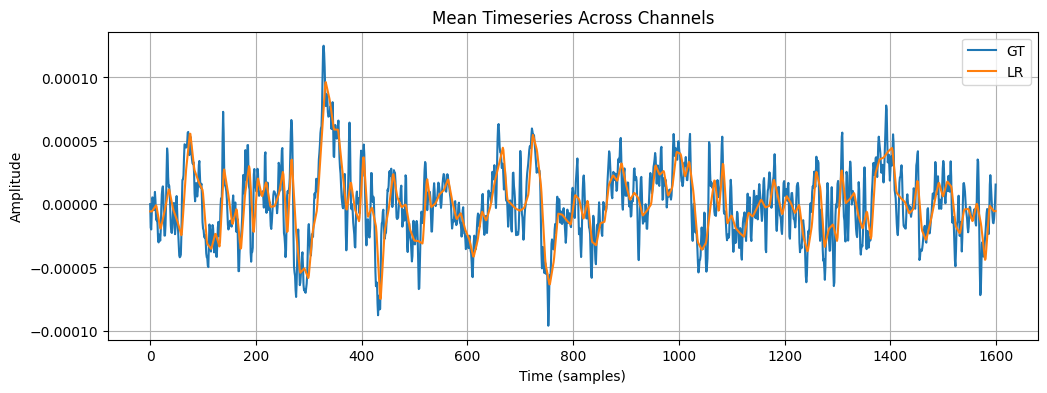


--- SR Type: spatial ---
Using simple bottleneck with residual internal
Using spatial SR: 8 channels to 64
Using simple bottleneck with residual internal
Using spatial SR: 16 channels to 64
Using simple bottleneck with residual internal
Using spatial SR: 32 channels to 64
=== Loading Datasets ===
Processing subject 23 (3/88)
Demo mode: stopping after 2 subjects.
✅ Number of segments created: 48
Processing subject 5 (3/22))
Demo mode: stopping after 2 subjects.
✅ Number of segments created: 48
Train and Test datasets loaded successfully.
=== Loading Datasets ===
Processing subject 23 (3/88)
Demo mode: stopping after 2 subjects.
✅ Number of segments created: 48
Processing subject 5 (3/22))
Demo mode: stopping after 2 subjects.
✅ Number of segments created: 48
Train and Test datasets loaded successfully.
=== Loading Datasets ===
Processing subject 23 (3/88)
Demo mode: stopping after 2 subjects.
✅ Number of segments created: 48
Processing subject 5 (3/22))
Demo mode: stopping after 2 subj

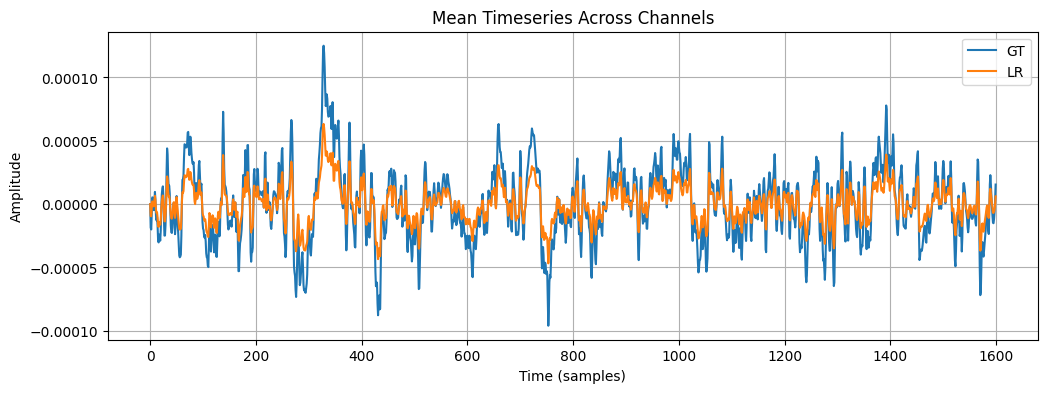

In [40]:
os.makedirs(models_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

for fold in range(nfolds):

    os.makedirs(os.path.join(models_path, f'fold_{fold+1}'), exist_ok=True)
    seed = seeds[fold]
    print(f"\n\n=================== Fold {fold+1}/{nfolds} - Seed: {seed} ===================")
    set_seed(seed)

    # Create train-test split
    patients = list(range(1, n_patients + 1))
    test_size = 0.2
    train_patients, test_patients = train_test_split(patients, test_size=test_size, random_state=seed)
    train_folder = data_path + os.sep + "train_data"
    test_folder = data_path + os.sep + "test_data"
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)


    for sr_type in sr_types:
        print(f"\n--- SR Type: {sr_type} ---")
        if sr_type == "temporal":
            num_channels = 64  # EEG channels
            downsample_factors = [2, 4, 8]  # Temporal SR upsampling factors
            models_nn = {}
            for downsample_factor in downsample_factors:
                fs_lr = int(fs_hr / downsample_factor)
                models_nn[f'x{downsample_factor}_with_subpixel_and_both_residuals'] = DCAE_SR_nn(num_channels=num_channels, fs_lr=fs_lr, fs_hr=fs_hr, seconds=seconds, residual_global=True, residual_internal=True, use_subpixel=True, sr_type=sr_type)   
            models, dataloaders_train, dataloaders_test = prepare_dataloaders(models_nn, sr_type, train_patients, test_patients, train_folder, test_folder, quick_load=quick_load, fold=fold, add_noise=False)                    
            data = next(iter(dataloaders_test[f'x{downsample_factor}_{sr_type}']))
            input, target = data
            timeseries = {}
            timeseries['GT'] = target.cpu().detach().numpy()
            lr_interpolated = torch.nn.functional.interpolate(input, scale_factor=downsample_factor, mode='linear', align_corners=False)
            timeseries['LR'] = lr_interpolated.cpu().detach().numpy()
            plot_mean_timeseries(timeseries)

        elif sr_type == "spatial":
            
            nums_channels = [8, 16, 32]  # Spatial SR scale factors
            models_nn = {}
            for num_channels in nums_channels:
                models_nn[f'{num_channels}to64_with_subpixel_and_both_residuals'] = DCAE_SR_nn(num_channels=num_channels, fs_lr=fs_hr, fs_hr=fs_hr, seconds=seconds, residual_global=True, residual_internal=True, use_subpixel=True, sr_type=sr_type)
            models, dataloaders_train, dataloaders_test = prepare_dataloaders(models_nn, sr_type, train_patients, test_patients, train_folder, test_folder, quick_load=quick_load, fold=fold, add_noise=False)  
            data = next(iter(dataloaders_test[f'{num_channels}to64_{sr_type}']))
            input, target = data
            timeseries = {}
            timeseries['GT'] = target.cpu().detach().numpy()
            lr_interpolated = add_zero_channels(input)
            timeseries['LR'] = lr_interpolated.cpu().detach().numpy()
            print(lr_interpolated.shape, target.shape)
            plot_mean_timeseries(timeseries)      